# Judge books by their cover using Flux.jl 
## @author : PseudoCodeNerd

> (Don't) judge a book by its cover.

### Task Description
Create a machine learning model to predict the category of a book from its cover image
This task is inspired by this [paper](https://arxiv.org/pdf/1610.09204.pdf). Your task is to use the Flux machine learning library to predict the category of books in this dataset based on their cover images.

You can find the Flux documentation [here](https://fluxml.ai/Flux.jl/stable/) and sample models for image categorization in the model zoo. We recommend starting with a simple model like [this](https://github.com/FluxML/model-zoo/blob/master/vision/mnist/mlp.jl) one and then optionally using a more complex one if you are interested.

### Aim : 
In this notebook, I'll attempt to judge a book by it's cover (sorry Mom!). Pretty Simple right ? I think not...
Shoutout to Akshat Mehortra and Mudit Somani for their helpful message in GCI Slack.

## 1. Importing required libraries.


In [2]:
using Flux
using CSV, Images, FileIO

## 2. Getting the data
Data is sourced from [The Book DatasSet](https://github.com/uchidalab/book-dataset). We'll use `FileIO` to get it into a variable.
It'd been better if the researcher could have made a script to download the full images in Julia also. I'll try doing that myself when I get some free time.

Data Courtesy : 
> B. K. Iwana, S. T. Raza Rizvi, S. Ahmed, A. Dengel, and S. Uchida, "Judging a Book by its Cover," arXiv preprint arXiv:1610.09204 (2016).

In [3]:
data_train_csv = CSV.File("book30-listing-train.csv");

In [4]:
data_train_csv[42]

7-element CSV.Row{false}:
  "520271181"                                                           
  "0520271181.jpg"                                                      
  "http://ecx.images-amazon.com/images/I/51s8awrmTRL.jpg"               
  "Becoming Dr. Q: My Journey from Migrant Farm Worker to Brain Surgeon"
  "Alfredo Quinones-Hinojosa"                                           
 1                                                                      
  "Biographies & Memoirs"                                               

So we can see that every item (or row here) is of the form,

**ID | FileName | Image URL | Title | Author | CategoryNum | Category**

From the data README on GitHub, we come to know that there are 30 categories of books, each 1710 train and 190 test images.

**Total Number of images : 51,300 (Train) | 5,700 (Test)** 

## 3. Data pre-processing

Our model will accept an image as a Floating Vector. I'll also convert it to greyscale as directed by Image Classification workflows in ML community. 

In [5]:
function grey_arr(img)
    return vec(Float64.(Gray.(img)))
end

grey_arr (generic function with 1 method)

### Creating batches of training images using Flux's `Batch` and using `onehot` for getting the categories of book images into another array.

In [17]:
function batcher(size)
    for x in data_train_csv[1:size]
        images = [grey_arr(load("./data/$(x[2])"))];
        labels = [Flux.onehot(x[6]+1,1:30)]; #plus 1 to account for 1 based indexing     
    end
    return (Flux.batch(images), Flux.batch(labels))
end

create_batch (generic function with 1 method)

Making batches of 2000/1000 book images using our newly created function.

In [18]:
trainbatch = batcher(2000);


In [19]:
trainbatch_2 = batcher(1000)

([0.7568627450980392 0.6 … 0.4117647058823529 0.12549019607843137; 0.6862745098039216 0.47058823529411764 … 0.4117647058823529 0.12549019607843137; … ; 0.8 0.22352941176470587 … 0.12941176470588234 0.2980392156862745; 0.9607843137254902 0.2784313725490196 … 0.12941176470588234 0.3529411764705882], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1])

## 4. Setting up our model, defining hyperparameters, adding loss, accuracy and optimiser functions. 
The image is of dimensions `224x224x3` so we'll feed our Vanilla Neural Network with a 224x224 input. The expected output is one of the 30 labels of the book genre.

Therefore,


In [8]:
const alpha = 0.000075;
const epoch = 20;


Using a NN with 3 layers as my fellow peers at GCI said that they were themselves unable to get a conv NN work.

relu as an activation function because it's my go to with image classification tasks and also of its non-saturation of gradient, which greatly accelerates the convergence of stochastic gradient descent compared to the sigmoid / tanh functions.

softmax to return a 30 element array with probabilities of the predicted labels.

In [9]:
model = Chain(Dense(224*224, 512, relu),
Dense(512, 64),
Dense(64, 30), softmax,
)

Chain(Dense(50176, 512, relu), Dense(512, 64), Dense(64, 30), softmax)

In [30]:
using Flux: onehotbatch, crossentropy, throttle
using Statistics

In [78]:
optim = ADAM(alpha);
loss(x,y) = Flux.crossentropy(model(x), y);
acc(a,b) = mean(Flux.onecold(model(a)).== Flux.onecold(b));
function mod_cb()
    c_acc = acc(trainbatch_2...)
    c_loss = loss(trainbatch_2...)
    print("Current Accuracy: ", string(c_acc), " | Current Loss : ", string(c_loss), " ;\n")
end

mod_cb (generic function with 1 method)

## 5. Training process

In [32]:
Flux.train!(loss, params(model), Iterators.repeated(trainbatch_2, 10), optim, cb = Flux.throttle(mod_cb, 10))

Current Accuracy: 0.075 | Current Loss : 7.827263 ;Current Accuracy: 0.057 | Current Loss : 7.081502 ;Current Accuracy: 0.04 | Current Loss : 5.475811 ;Current Accuracy: 0.049 | Current Loss : 4.304302 ;

In [33]:
Flux.train!(loss, params(model), Iterators.repeated(trainbatch, 10), optim, cb = Flux.throttle(mod_cb, 10))

Current Accuracy: 0.083 | Current Loss : 4.1588893 ;Current Accuracy: 0.082 | Current Loss : 3.8012412 ;Current Accuracy: 0.07 | Current Loss : 3.4713938 ;Current Accuracy: 0.102 | Current Loss : 3.3677185 ;

we can see that the accuracy nearly doubled, Lets train it further and also the iterations.

In [34]:
trainbatch_3 = create_batch(3000)
Flux.train!(loss, params(model), Iterators.repeated(trainbatch, 50), optim, cb = Flux.throttle(mod_cb, 10))

Current Accuracy: 0.101 | Current Loss : 3.3449063 ;Current Accuracy: 0.103 | Current Loss : 3.2926059 ;Current Accuracy: 0.123 | Current Loss : 3.228091 ;Current Accuracy: 0.141 | Current Loss : 3.1849866 ;Current Accuracy: 0.142 | Current Loss : 3.1404302 ;Current Accuracy: 0.137 | Current Loss : 3.1053653 ;Current Accuracy: 0.156 | Current Loss : 3.0754461 ;Current Accuracy: 0.154 | Current Loss : 3.0544689 ;Current Accuracy: 0.166 | Current Loss : 3.0326622 ;Current Accuracy: 0.181 | Current Loss : 3.0075598 ;Current Accuracy: 0.193 | Current Loss : 2.9763196 ;Current Accuracy: 0.192 | Current Loss : 2.9434323 ;Current Accuracy: 0.216 | Current Loss : 2.920823 ;Current Accuracy: 0.227 | Current Loss : 2.893316 ;Current Accuracy: 0.232 | Current Loss : 2.8663476 ;Current Accuracy: 0.253 | Current Loss : 2.8385205 ;Current Accuracy: 0.255 | Current Loss : 2.8103878 ;

We get a train accuracy of **25.5 %** which is swell.

## 6. Testing Time


In [100]:
loss(trainbatch_3...)


3.0033288f0

In [99]:
acc(trainbatch_3...)

0.19166666666666668

Loading and predicting label for a new image.

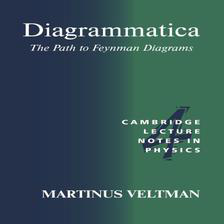

In [109]:
load("./data/$(data_test_csv[7][2])")

In [110]:
data_test_csv[7]

7-element CSV.Row{false}:
   "521456924"                                                                       
   "0521456924.jpg"                                                                  
   "http://ecx.images-amazon.com/images/I/41n7iZq-0jL.jpg"                           
   "Diagrammatica: The Path to Feynman Diagrams (Cambridge Lecture Notes in Physics)"
   "Martinus Veltman"                                                                
 23                                                                                  
   "Science & Math"                                                                  

In [113]:
output_arr = model(grey_arr(load("./data/$(data_train_csv[69][2])")))

30-element Array{Float32,1}:
 0.027294824 
 0.008443545 
 0.032920413 
 0.008069489 
 0.016592907 
 0.010181716 
 0.13866615  
 0.03892814  
 0.02634485  
 0.03132174  
 0.0062278663
 0.04601992  
 0.008348866 
 ⋮           
 0.025657153 
 0.010952779 
 0.0171675   
 0.06719829  
 0.010065774 
 0.0694461   
 0.02233742  
 0.034847874 
 0.024896467 
 0.01961776  
 0.01895972  
 0.042962853 

In [119]:
maxval = maximum(output_arr)

0.13866615f0

In [122]:
findall(x -> x==maxval, output_arr)


1-element Array{Int64,1}:
 7

7 acc to the Labels and Categories of the images is the **Computers & Technology** however it should be Science & Math. Pretty Close I must say


## Thank You!